# Create raster masks using the NSW DOI Water irrigated crop extent validation datasets

**What does this notebook do?** This notebook demonstrates how to create a raster mask using a shapefile. It uses `rasterio` to 'burn' the polygon extent of each feature from a shapefile into a new raster, based off the extent of a Geotiff. 

This notebook creates a raster the same shape as the Namoi Catchment geotiffs, and creates a raster mask using the NSW DOI Water irrigated crop extent validation datasets.

**Outputs**
* `NSWDOIwaterMask_2012.pkl`
* `NSWDOIwaterMask_2013.pkl`

**Date:** May 2018

**Author:** Claire Krause

In [1]:
%pylab notebook

import xarray as xr
import rasterio
import rasterio.features
import geopandas as gp
import glob
import pickle

Populating the interactive namespace from numpy and matplotlib


## Read in the NSW Landuse shapefile, and any Namoi Geotiff (just to grab extents for the mask)

We have two validation crop area shapefiles provided by NSW DOI Water - 2012 and 2013. (Note that there are also validation files for 2004 and 2008, however we have not processed accompanying NDVI data, so we will ignore these for now).

In [2]:
year = '2013'

shape_file = '/g/data/r78/cek156/NSWDOI_IrrigatedCropExtents/CropArea_Namoi_Landsat{0}_Jan_Mar_withLanduse.shp'.format(
    year)

In [3]:
# Any dea-stats produced file just so we can grab the extents for the mask
StatsFile = '/g/data/r78/cek156/datacube_stats/Namoi_summer/NDVI/withls7/ndvi_None_20131101.tif'

### We need to re-open the NDVI file with rasterio, and the shapefile with geopandas (not the most elegant solution, but it works)

In [4]:
GeotiffData_rasterio = rasterio.open(StatsFile)

# Open the Geotiff so we can get the x and y coordinates for later on
GeotiffData = xr.open_rasterio(StatsFile)

In [5]:
shp = gp.read_file(shape_file)

# Reproject coordinate system of shape file
shp = shp.to_crs({'init': 'epsg:3577'})

I am densified (external_values, 1220 elements)


### Iterate over each of the polygons, and put a '1' in the mask raster that corresponds to the footprint of each polygon

In [6]:
mask = rasterio.features.rasterize(((feature['geometry'], 1) for feature in shp.iterfeatures()),
            out_shape=GeotiffData_rasterio.shape,
            transform=GeotiffData_rasterio.transform)

In [7]:
# Convert '0' values to 'nan'
mask = mask.astype('float_')
mask[mask == 0] = np.nan

In [8]:
# Convert the numpy array to a DataArray
mask = xr.DataArray(mask, coords=(GeotiffData.y, GeotiffData.x))

<IPython.core.display.Javascript object>


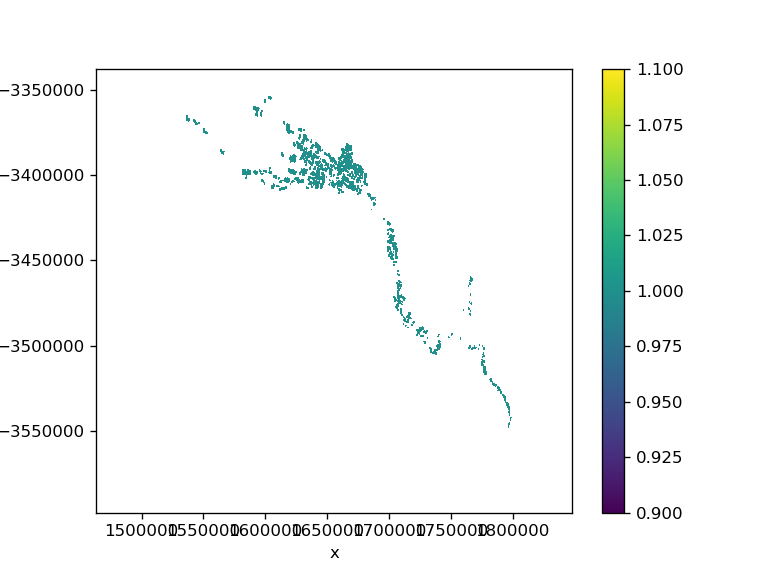

In [9]:
plt.figure()
mask.isel(x = range(0,len(GeotiffData.x),10), y = range(0,len(GeotiffData.y),10)).plot()

### Pickle out the mask for later on

In [10]:
with open('NSWDOIwaterMask_{0}.pkl'.format(year), 'wb') as f:
    pickle.dump(mask, f, -1)